# Transverse Ising chain with linear dissipation

In [1]:
include("notebook_preamble.jl")

## Utility functions

In [2]:
tpow(x, n) = ⊗(repeat([x], n)...)
acomm(x, y) = x*y + y*x
trnorm = tracenorm ∘ dense
function acomm_table(a, b, N)
    reshape([trnorm(acomm(a(i), b(j))) / 2^N
            for i in 1:N for j in 1:N],
        (N, N)) |> LowerTriangular |> display
end
function acomm_tables(c, N=Int(log2(size(c(1))[1])))
    ct = dagger ∘ c
    acomm_table(ct, c, N)
    acomm_table(c, c, N)
    acomm_table(ct, ct, N)
end
;

## Spins

First, we set up the spin-1/2 sites and Pauli operators.

In [3]:
sb = SpinBasis(1//2)
sx, sy, sz, sp, sm = sigmax(sb), sigmay(sb), sigmaz(sb), sigmap(sb), sigmam(sb)
up, down = spinup(sb), spindown(sb)
ψx = eigenstates(dense(sx))[2][1];

## Ising model

To create a $N$-site spin loop, we need to construct the basis for the loop and operators for each site.

In [4]:
N = 4
sB = tpow(sb, N)
I = identityoperator(sB)
site(i, op) = embed(sB, (i-1)%N + 1, op); # Periodic boundary

We now construct the transverse-field Ising Hamiltonian (Pfeuty)
$$
\frac{\ham}{\Gamma}
= - \sum_i \opr{S}_z^i
- \frac{J}{\Gamma} \sum_{i=1}^N \opr{S}_i^x \opr{S}_{i+1}^x ,
$$
where $2\lambda = J / \Gamma$.

In [5]:
λ = 1.5 # Pfeuty with Γ=1, so 
Hs = -sum(site(i, sz)/2 + 2λ*site(i, sx)*site(i+1, sx)/4 for i in 1:N);

## Fermion definitions

In [6]:
k(m) = 2π*(m-1)/N - π*(N - (N%2))/N; # for m in 1:N
function c(i) # for i in 1:N
    i = (i-1)%N + 1 
    A = -(i == 1
        ? I
        : prod(-site(j, sz) for j in 1:(i-1)))
    A * site(i, sm)
end
ct(i) = dagger(c(i))
;

In [7]:
csx(i) = -(i == 1 ? I : prod(I - 2*ct(j)*c(j) for j in 1:(i-1))) * (ct(i) + c(i))
[csx(i) - site(i, sx) for i in 1:N] .|> dense .|> tracenorm

4-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0

Pfeuty, assuming Pfeuty's $\lambda$:

In [8]:
L = sum(ct(i)*c(i) for i in 1:N)
Hend = (λ/2) * (ct(N) - c(N))*(ct(1) + c(1))*((sparse ∘ exp ∘ dense)(im*π*L) + I);
Hc = I*(N/2) + Hend - sum(
    ct(i)*c(i) + (λ/2) * (ct(i) - c(i))*(ct(i+1) + c(i+1))
    for i in 1:N);

In [9]:
(tracenorm ∘ dense)(Hs - Hc)

8.241088489530144e-15

It looks like the trace norm of the boundary term relative to that of the whole Hamiltonian diminishes with increasing $N$. But does this imply that it may be dropped?

In [10]:
(tracenorm ∘ dense)(Hend) / (tracenorm ∘ dense)(Hs)

0.585893266131237

Striff: Works for all cases.

In [11]:
λS = -1 / λ
E(m) = √(λS^2 - 2λS*cos(k(m)) + 1)
C(k) = sum(exp(-im*k*i) * c(i) for i in 1:N) / √N
Ct(k) = dagger(C(k))
aS(m) = (N%2 == 0 && m == 1 ? 0 : -im*sin(k(m)) / √(2E(m)*(E(m) + cos(k(m)) - λS)))
bS(m) = (N%2 == 0 && m == 1 ? 1 : √((E(m) + cos(k(m)) - λS) / (2E(m))))
ηS(m) = aS(m)*C(k(m)) + bS(m)*Ct(-k(m))
ηSt(m) = dagger(ηS(m));

In [29]:
acomm_tables(ηS)

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 1.0           ⋅            ⋅            ⋅ 
 3.79912e-17  1.0           ⋅            ⋅ 
 6.12323e-17  3.79912e-17  1.0           ⋅ 
 1.15513e-16  3.39656e-17  3.79912e-17  1.0

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.0           ⋅            ⋅            ⋅ 
 6.03652e-17  5.09484e-17   ⋅            ⋅ 
 0.0          2.06412e-17  0.0           ⋅ 
 2.06412e-17  1.07852e-32  2.06412e-17  5.09484e-17

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.0           ⋅            ⋅            ⋅ 
 6.03652e-17  5.09484e-17   ⋅            ⋅ 
 0.0          2.06412e-17  0.0           ⋅ 
 2.06412e-17  1.07852e-32  2.06412e-17  5.09484e-17

Pfeuty: $\eta$'s do not satisfy the CARs? Typo, or **problem**?

In [13]:
Λ(m) = √(λ^2 + 2λ*cos(k(m)) + 1)
ϕ(k, i) = √(2/N) * (k > 0 ? sin(k*i) : cos(k*i))
ψ(k, i) = -((1 + λ*cos(k))*ϕ(k, i) + λ*sin(k)*ϕ(-k, i)) / Λ(k)
a(m, i) = (ϕ(k(m), i) + ψ(k(m), i)) / 2
b(m, i) = (ϕ(k(m), i) - ψ(k(m), i)) / 2
η(m) = sum(a(m, i)*c(i) + b(m, i)*ct(i) for i in 1:N)
ηt(m) = dagger(η(m));

In [14]:
acomm_tables(η)

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 1.77185       ⋅            ⋅            ⋅ 
 1.14925e-17  0.817209      ⋅            ⋅ 
 6.93889e-18  6.37511e-17  2.92308       ⋅ 
 1.19262e-17  3.80555e-17  1.86591e-16  1.67993

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.228148      ⋅            ⋅            ⋅ 
 5.00901e-17  0.182791      ⋅            ⋅ 
 6.93889e-18  4.42354e-17  0.923077      ⋅ 
 1.03975e-16  4.99817e-17  1.12323e-16  0.679928

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.228148      ⋅            ⋅            ⋅ 
 5.00901e-17  0.182791      ⋅            ⋅ 
 6.93889e-18  4.42354e-17  0.923077      ⋅ 
 1.03975e-16  4.99817e-17  1.12323e-16  0.679928

In [15]:
E0 = -sum(Λ(m) for m in 1:N) / 2;
Hη = sum(Λ(m)*ηt(m)*η(m) for m in 1:N) + E0*I;

In [16]:
((tracenorm ∘ dense)((Hs - Hend) - Hη), (tracenorm ∘ dense)(Hs - Hη)) ./ 2^N

(3.0484190555847563, 3.303757185973999)

## Starting from the many-body basis instead

In [17]:
f = NLevelBasis(N) # "Levels" 1 to N are indices of k's
mbb = ManyBodyBasis(f, fermionstates(f, [0:N...]))
ηmb(m) = destroy(mbb, m)
ηtmb(m) = create(mbb, m)
Hf = diagonaloperator(f, @. Λ(k(1:N)) + E0)
Hmb = manybodyoperator(mbb, Hf);

In [18]:
A = reshape([a(m, i) for i in 1:N for m in 1:N], (N, N))
B = reshape([b(m, i) for i in 1:N for m in 1:N], (N, N))
η2c = inv([A B; conj(B) conj(A)]);

In [19]:
ηmbs = [[ηmb(m) for m in 1:N]; [ηtmb(m) for m in 1:N]]
cmbs = η2c * ηmbs
cmb(i) = cmbs[i];
cmbt(i) = cmbs[i+N];

In [20]:
[cmbt(i) - dagger(cmb(i)) for i in 1:N] .|> dense .|> tracenorm

4-element Array{Float64,1}:
 1.6712244084025288e-15
 7.113552910039463e-16
 1.9700498566812406e-15
 1.2917501847280224e-15

## Checks that definitions are correct

Anticommutation relations:

In [21]:
acomm_tables(c)

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 1.0   ⋅    ⋅    ⋅ 
 0.0  1.0   ⋅    ⋅ 
 0.0  0.0  1.0   ⋅ 
 0.0  0.0  0.0  1.0

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.0   ⋅    ⋅    ⋅ 
 0.0  0.0   ⋅    ⋅ 
 0.0  0.0  0.0   ⋅ 
 0.0  0.0  0.0  0.0

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.0   ⋅    ⋅    ⋅ 
 0.0  0.0   ⋅    ⋅ 
 0.0  0.0  0.0   ⋅ 
 0.0  0.0  0.0  0.0

In [22]:
acomm_tables(ηS)

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 1.0           ⋅            ⋅            ⋅ 
 3.79912e-17  1.0           ⋅            ⋅ 
 6.12323e-17  3.79912e-17  1.0           ⋅ 
 1.15513e-16  3.39656e-17  3.79912e-17  1.0

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.0           ⋅            ⋅            ⋅ 
 6.03652e-17  5.09484e-17   ⋅            ⋅ 
 0.0          2.06412e-17  0.0           ⋅ 
 2.06412e-17  1.07852e-32  2.06412e-17  5.09484e-17

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.0           ⋅            ⋅            ⋅ 
 6.03652e-17  5.09484e-17   ⋅            ⋅ 
 0.0          2.06412e-17  0.0           ⋅ 
 2.06412e-17  1.07852e-32  2.06412e-17  5.09484e-17

In [23]:
acomm_tables(η)

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 1.77185       ⋅            ⋅            ⋅ 
 1.14925e-17  0.817209      ⋅            ⋅ 
 6.93889e-18  6.37511e-17  2.92308       ⋅ 
 1.19262e-17  3.80555e-17  1.86591e-16  1.67993

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.228148      ⋅            ⋅            ⋅ 
 5.00901e-17  0.182791      ⋅            ⋅ 
 6.93889e-18  4.42354e-17  0.923077      ⋅ 
 1.03975e-16  4.99817e-17  1.12323e-16  0.679928

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.228148      ⋅            ⋅            ⋅ 
 5.00901e-17  0.182791      ⋅            ⋅ 
 6.93889e-18  4.42354e-17  0.923077      ⋅ 
 1.03975e-16  4.99817e-17  1.12323e-16  0.679928

In [24]:
acomm_tables(ηmb)

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 1.0   ⋅    ⋅    ⋅ 
 0.5  1.0   ⋅    ⋅ 
 0.5  0.5  1.0   ⋅ 
 0.5  0.5  0.5  1.0

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.0   ⋅    ⋅    ⋅ 
 0.5  0.0   ⋅    ⋅ 
 0.5  0.5  0.0   ⋅ 
 0.5  0.5  0.5  0.0

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.0   ⋅    ⋅    ⋅ 
 0.5  0.0   ⋅    ⋅ 
 0.5  0.5  0.0   ⋅ 
 0.5  0.5  0.5  0.0

In [25]:
acomm_tables(cmb)

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.793882   ⋅         ⋅         ⋅ 
 0.497777  0.683066   ⋅         ⋅ 
 0.58617   0.529732  0.793882   ⋅ 
 0.529732  0.462033  0.497777  0.683066

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.741114   ⋅         ⋅         ⋅ 
 0.454288  0.510739   ⋅         ⋅ 
 0.550448  0.480828  0.741114   ⋅ 
 0.480828  0.316564  0.454288  0.510739

4×4 LowerTriangular{Float64,Array{Float64,2}}:
 0.741114   ⋅         ⋅         ⋅ 
 0.454288  0.510739   ⋅         ⋅ 
 0.550448  0.480828  0.741114   ⋅ 
 0.480828  0.316564  0.454288  0.510739

## Construction of superoperators

TODO: Sort spectrum to group projectors together, etc.

## Time evolution

We start the system off with all $x$-oriented spins.

In [26]:
# ψs = tpow(down, N);
ψs = tpow(ψx, N);

Now we time-evolve the system and look at the expectation values of some reduced operators on the spin chain. We start with just the isolated chain.

In [27]:
fout(t, ρ) = real([
        expect(site(1, sz), ρ)
        expect(embed(sB, [1, 2], [sz, sz]), ρ)
        expect(site(1, sx), ρ)
        ])
ts, fouts = timeevolution.schroedinger([0:0.05:20;], ψs, Hs, fout=fout);

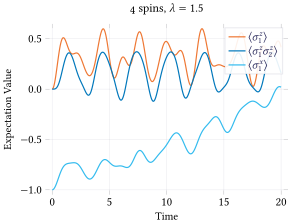

In [28]:
plot(xlabel="Time", ylabel="Expectation Value")
plot!(ts, hcat(fouts...)',
    title = latexstring("$N spins, \$\\lambda = $λ\$"),
    label = [
        L"\left\langle\pauli_1^z\right\rangle"
        L"\left\langle\pauli_1^z\pauli_2^z\right\rangle"
        L"\left\langle\pauli_1^x\right\rangle"
        ])